CHANGE THE OUTPUT SIZE OF THE CLASSIFIVATION + ADD VALIDATION TRAIN

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt # for plotting
import torch.optim as optim #for gradient descent
import torchvision
#import torchvision.transforms as transforms
#from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

torch.manual_seed(1) # set the random seed
print(torch.__version__, torch.cuda.is_available())

use_cuda = True

2.0.0+cu118 True


In [44]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

ModuleNotFoundError: No module named 'google'

In [4]:
#load data
#location on Google Drive
master_path = '../data_processing/embeddings/'

#loading train data
train_features = torchvision.datasets.DatasetFolder(master_path + 'embeddingtrain2', loader=torch.load, extensions=('.tensor'))

#loading validation data
validation_features = torchvision.datasets.DatasetFolder(master_path + 'embeddingval2', loader=torch.load, extensions=('.tensor'))

#loading test data

In [5]:
from torch.utils.data import Subset
# Get the total number of samples in the dataset
dataset_size = len(train_features)

# Calculate the number of samples to include in the subset
subset_size = int(0.3 * dataset_size)

# Generate a list of random indices for the subset
subset_indices = torch.randperm(dataset_size)[:subset_size]

# Create a Subset using the subset indices
subset_train_features = Subset(train_features, subset_indices)

# Get the total number of samples in the dataset
dataset_size = len(validation_features)

# Calculate the number of samples to include in the subset
subset_size = int(0.3 * dataset_size)

# Generate a list of random indices for the subset
subset_indices = torch.randperm(dataset_size)[:subset_size]

# Create a Subset using the subset indices
subset_validation_features = Subset(validation_features, subset_indices)

# Defining and Training the Model

In [34]:
#defining the model - CNN with one convolution, make it into it
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(1024, 1048, 3, 1, 1) #input is over 1000
        self.pool = nn.MaxPool2d(2, 2)
        self.act1 = nn.LeakyReLU()
        self.act2 = nn.LeakyReLU()
        self.act3 = nn.LeakyReLU()
        self.act4 = nn.LeakyReLU()
        self.act5 = nn.Mish()
        self.act6 = nn.Mish()
        self.fc1 = nn.Linear(3*3*1048, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, 256)
        self.fc5 = nn.Linear(256, 96)
        self.out = nn.Linear(96, 15) # CHANGE TO

    def forward(self, x):
        x = self.pool(self.act1(self.conv1(x)))
        x = x.view(-1, 3*3*1048)
        x = self.act2(self.fc1(x))
        x = self.act3(self.fc2(x))
        x = self.act4(self.fc3(x))
        x = self.act5(self.fc4(x))
        x = self.act6(self.fc5(x))
        return self.out(x)

model = Classifier()

In [26]:
#defining accuracy
def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    for imgs, labels in data_loader:
      if use_cuda and torch.cuda.is_available():
        imgs = imgs.cuda()
        labels = labels.cuda()
      #feeds 64 images to the model
      output = model(imgs)
      #select index with maximum prediction score
      pred = F.softmax(output, dim=1).max(1, keepdim=True)[1]
      correct += pred.eq(labels.view_as(pred)).sum().item()
      total += imgs.shape[0]
    return correct / total


In [ ]:
# accuracy sanity check
data_loader = torch.utils.data.DataLoader(train_features, batch_size=256)

get_accuracy(model, data_loader)

In [36]:
#defining the train function
def train(model, train_data, validation_data, batch_size=512, num_epochs=1 , print_stat = True):
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
    validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0005)

    iters, losses, train_acc, val_acc, epochs = [], [], [], [], []
    #iters, losses, train_acc, epochs = [], [], [], []
    if use_cuda and torch.cuda.is_available():
       model = model.to("cuda:0")
    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        total_train_loss = 0
        for imgs, labels in train_loader:

            if use_cuda and torch.cuda.is_available():
              imgs = imgs.to("cuda:0")
              labels = labels.to("cuda:0")
              
            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            n += 1
            # print(n)

            total_train_loss += loss

        # save the current training information
        train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy 
        val_acc.append(get_accuracy(model, validation_loader))  # compute validation accuracy
        #losses.append(float(loss)/batch_size)             # compute *average* loss
        losses.append(float(total_train_loss)/batch_size)
        epochs.append(epoch)

        print("Epoch ", epoch, ", accuracy: ", train_acc[epoch], ", loss: ", losses[epoch])
    if print_stat:
      # plotting
      plt.title("Training Curve")
      plt.plot(epochs, losses, label="Train")
      plt.xlabel("Iterations")
      plt.ylabel("Loss")
      plt.show()

      plt.title("Training Curve")
      plt.plot(epochs, train_acc, label="Train")
      plt.plot(epochs, val_acc, label="Validation")
      plt.xlabel("Iterations")
      plt.ylabel("Training Accuracy")
      plt.legend(loc='best')
      plt.show()

      print("Final Training Accuracy: {}".format(train_acc[-1]))
      print("Final Validation Accuracy: {}".format(val_acc[-1]))
    return model

Epoch  0 , accuracy:  0.10788713773788401 , loss:  0.4015357494354248
Epoch  1 , accuracy:  0.09024806039731413 , loss:  0.28682470321655273
Epoch  2 , accuracy:  0.10068538426747382 , loss:  0.29699262976646423
Epoch  3 , accuracy:  0.10037226455136902 , loss:  0.323442667722702
Epoch  4 , accuracy:  0.10072017534704102 , loss:  0.26080164313316345


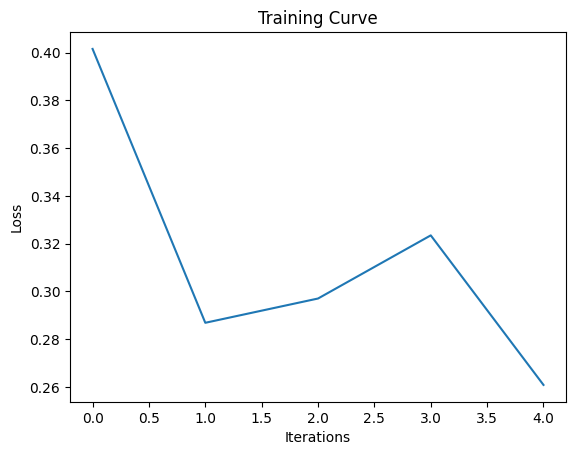

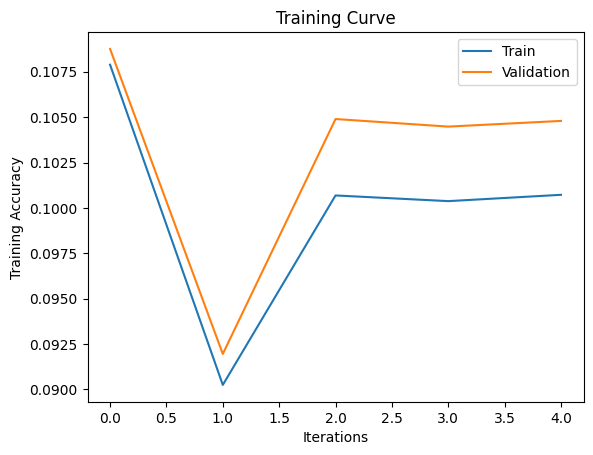

Final Training Accuracy: 0.10072017534704102
Final Validation Accuracy: 0.1047907316564033


In [37]:
#training the model
model = Classifier()
model = train(model, train_features, validation_features, num_epochs=5)
torch.save(model.state_dict(), "./baseline.mdlckpt")

# Getting accuracy score per class

In [39]:
nb_classes = 15

correct_pred = [0]*nb_classes
total_pred = [0]*nb_classes

#data_features = torchvision.datasets.DatasetFolder(master_path, loader=torch.load, extensions=('.tensor'))
data_loader = torch.utils.data.DataLoader(train_features, batch_size=2048)

#delete
n = 0
with torch.no_grad():
    for inputs, labels in data_loader:
        if use_cuda and torch.cuda.is_available():
            inputs = inputs.to("cuda:0")
            labels = labels.to("cuda:0")
        n += 1
        out = model(inputs)
        out = F.softmax(out, dim=1)
        predicted = out.max(1)[1]

        for i in range(len(labels)):
            label = labels[i]
            correct_pred[label] += (predicted[i] == label).item()
            total_pred[label] += 1

accuracy_per_class = np.array(correct_pred) / np.array(total_pred)

print("Correct predictions: ", correct_pred)
print("Total predictions: ", total_pred)
print("Accuracy score per class: ", accuracy_per_class)
print("Total Accuracy: ", np.sum(correct_pred) / np.sum(total_pred))

Correct predictions:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2893]
Total predictions:  [2535, 658, 756, 386, 2376, 539, 437, 70, 5730, 1272, 6049, 1593, 698, 2750, 2894]
Accuracy score per class:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.30633163e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 9.99654457e-01]
Total Accuracy:  0.10072017534704102


In [24]:
np.savetxt("baseline_results.csv", accuracy_per_class, delimiter=",")